In [210]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from pykalman import KalmanFilter

# Clase DataSet para instanciar cada experimento  

In [8]:
class DataSet:
    def __init__(self, test, run):
        self.test = test
        self.run = run
        self.path = 'MOSFET_Thermal_Overstress_Aging_v0/Test_{}_run_{}.mat'
        self.data_set = None
        self.data_set_on = None
        self.initialize()
        
    
    def __str__(self):
        msg = f"Información experimento {self.test} run {self.run}"
        return msg

    def initialize(self):
        self.document_reader()
        self.df_filter()
    
    def document_reader(self):
        # Solo se crean cuando se instancian estas listas
        time_pwm = list()
        pwm_list = list()
        time_open = list()
        time_df = list()
        drain_currrent_df = list()
        ds_voltage_df = list()
        temperature_df = list()

        # Cargar el archivo .mat

        # Liste de tuplas que incluye el tiempo donde gateState == 1. Estas tuplas van de (tiempo apertura, tiepo cierre) y el tiempo de cierre es el siguiente momento donde gateState == 0.
        # Si el experimento termina en gateState == 1, el tiempo de cierre es infinito.
        t_last = 0
        t_init = 0
        # Leer el archivo .mat
        for i in range(self.run):
            path = self.path.format(self.test, i+1)
            try:
                measurement = scipy.io.loadmat(path, squeeze_me=True, struct_as_record=False)['measurement']
            except FileNotFoundError:
                print(f"Archivo {path} no encontrado.")
            except Exception as e:
                print(f"Error al cargar el archivo {path}: {e}")
                continue
            # Acceder al campo 'steady'
            steady = measurement.steadyState 
            init = True
            for measure in steady:
                if init:
                    t_init = datetime.strptime(measure.date, '%m/%d/%Y %H:%M:%S.%f').timestamp()
                    init = False
                fecha_dt = datetime.strptime(measure.date, '%m/%d/%Y %H:%M:%S.%f').timestamp()- t_init+ t_last
                time_df.append(fecha_dt) 

                # Leer corriente del drain 
                drain_current_n = measure.timeDomain.drainCurrent
                drain_currrent_df.append(drain_current_n)

                # Leer voltaje drain-source
                ds_voltage_n = measure.timeDomain.drainSourceVoltage
                ds_voltage_df.append(ds_voltage_n)

                # Leer temperatura
                temperature_n = measure.timeDomain.flangeTemperature
                temperature_df.append(temperature_n)
            # Aqui hago dataframe de pandas para filtrar los datos.
            # Filtro solo la corriente y voltajes que se encuentran en los intervalos de tiempo donde gateState == 1.
            t_last = fecha_dt+ 1 # Incremento de 1 segundo para el siguiente experimento
        df = pd.DataFrame({'time': time_df, 'drain_current': drain_currrent_df, 'ds_voltage': ds_voltage_df , 'temperature': temperature_df})
        df["R_ds"] = df["ds_voltage"]/df["drain_current"] # Resistencia entre drain y source
                #df['time'] = pd.to_datetime(df['time'], unit='s')
                #dfs = [df[(df["time"] >= start) & (df["time"] <= end)] for start, end in time_open]
                #filtered_df = pd.concat(dfs).sort_index()
            
        self.data_set = df


    def min_max_normalization(self):
        #self.data_set["R_ds"] = gaussian_filter1d(self.data_set["R_ds"], sigma=5) # Suavizado de la resistencia entre drain y source
        Min = self.data_set["R_ds"].min()
        Max = self.data_set["R_ds"].max()
        self.data_set["R_ds Min Max Norm"] = self.data_set["R_ds"].apply(lambda x: (x- Min)/(Max - Min))


    def set_r0(self):
        self.data_set_on["R_ds Min Max Norm"] =gaussian_filter1d(self.data_set_on["R_ds Min Max Norm"], sigma=10) # Normalización de la resistencia entre drain y source
        init_value = self.data_set_on["R_ds Min Max Norm"].iloc[0]
        self.data_set_on["R_ds Min Max Norm"] = self.data_set_on["R_ds Min Max Norm"].apply(lambda x: (x - init_value))

    def pwm_on_filter(self):
        i_rms = np.sqrt(np.mean(self.data_set["drain_current"]**2)) # RMS de la corriente del drain
        self.data_set_on = self.data_set[(self.data_set["drain_current"] > (i_rms/2))]

    def df_filter(self):
        time_init = self.data_set["time"].iloc[0]
        self.data_set["time"] = self.data_set["time"].apply(lambda x: (x - time_init)/60)
        self.min_max_normalization()
        self.pwm_on_filter()
        self.filter_current()
        self.set_r0()
        
    def filter_current(self):
        self.data_set_on = self.data_set_on[self.data_set_on["drain_current"] < self.data_set_on["drain_current"].quantile(0.95)]
        
        

# Instancias de Data sets

In [9]:
from numpy.fft import fft, fftfreq


In [10]:
data_36 = DataSet(36,1)

df_36 = data_36.data_set
df_on_36 = data_36.data_set_on

In [11]:
data_11 = DataSet(11,7)
df_11 = data_11.data_set
df_on_11 = data_11.data_set_on


In [12]:
data_9 = DataSet(9, 7)
df_9 = data_9.data_set
df_on_9 = data_9.data_set_on

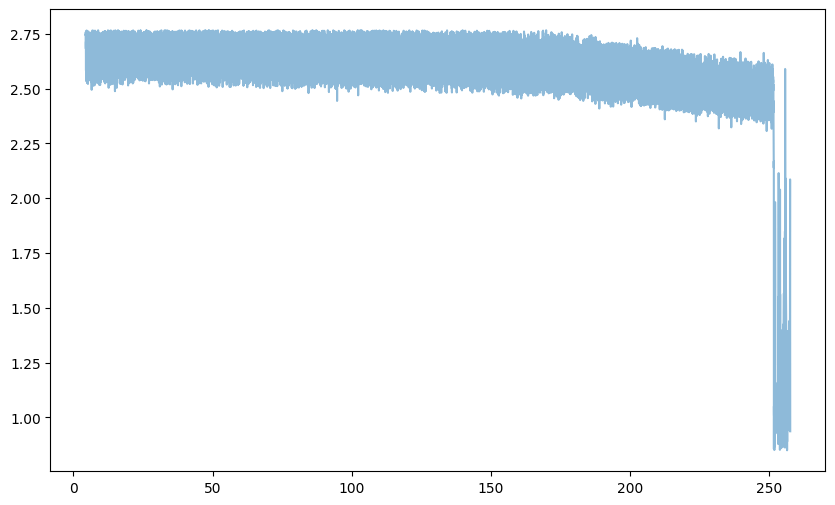

In [13]:
#plot current
plt.figure(figsize=(10, 6))

plt.plot(df_on_36["time"], df_on_36["drain_current"], label='Test 36', alpha=0.5) 

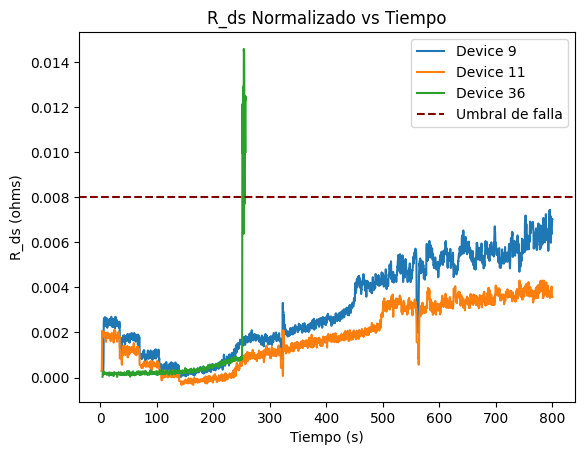

In [14]:

plt.plot(df_on_9["time"], gaussian_filter1d(df_on_9["R_ds Min Max Norm"], sigma=10), label="Device 9")
plt.plot(df_on_11["time"], gaussian_filter1d(df_on_11["R_ds Min Max Norm"], sigma=10), label="Device 11")
plt.plot(df_on_36["time"], gaussian_filter1d(df_on_36["R_ds Min Max Norm"], sigma=10), label="Device 36")

plt.axhline(y = 0.008, linestyle = "--", color = "maroon", label = "Umbral de falla")
plt.title("R_ds Normalizado vs Tiempo")
plt.xlabel("Tiempo (s)")
plt.ylabel("R_ds (ohms)")
plt.legend()
plt.show()

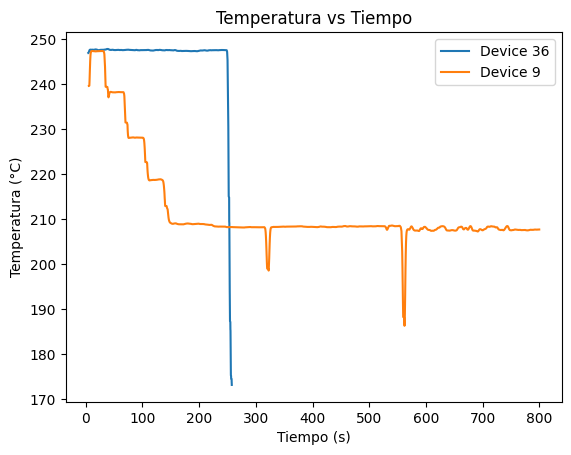

In [15]:
plt.plot(df_on_36["time"], gaussian_filter1d(df_on_36["temperature"], sigma = 100), label="Device 36")
plt.plot(df_on_9["time"], gaussian_filter1d(df_on_9["temperature"], sigma = 100), label="Device 9")
#plt.plot(df_on_10["time"], gaussian_filter1d(df_on_10["temperature"], sigma = 100), label="Device 2")
plt.title("Temperatura vs Tiempo")
plt.xlabel("Tiempo (s)")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.show()

# Datos para ajustar 

In [222]:
fit_9 = pd.DataFrame({"time":df_on_9["time"], "R_ds": df_on_9["R_ds Min Max Norm"]})
fit_11 = pd.DataFrame({"time":df_on_11["time"], "R_ds": gaussian_filter1d(df_on_11["R_ds Min Max Norm"], sigma=10)})
fit_36 = pd.DataFrame({"time":df_on_36["time"], "R_ds": gaussian_filter1d(df_on_36["R_ds Min Max Norm"], sigma=10)})

In [237]:
def func_2(t,a,b):
    f = a *(np.exp(b*t) - 1)
    return f

In [248]:
largo = len(fit_9["time"])

In [243]:
smooth_9_savgol = savgol_filter(fit_9["R_ds"], window_length=1000, polyorder=3)

In [288]:
# Meter filtro de kalman

R_ds = fit_9["R_ds"][:(2*largo)//3]
print(R_ds)

kf = KalmanFilter(
    initial_state_mean=R_ds.iloc[0],       # Valor inicial
    initial_state_covariance=1,       # Incertidumbre inicial
    observation_covariance=1000,       # Ruido en las mediciones (ajústalo)
    transition_covariance=0.1,       # Ruido en el modelo (ajústalo)
    transition_matrices=[1]           # Modelo dinámico (1 = sin transición)
)

smooth_9_kalman, r = kf.smooth(R_ds)
filter_9_kalman, _ = kf.filter(R_ds)
future_R_ds = []
n_prediction = largo - (2*largo)//3
future_time = fit_9["time"]
last_state = smooth_9_kalman[-1]

for r in range(n_prediction):
    last_state, r = kf.filter_update(last_state,filtered_state_covariance=100)
    future_R_ds.append(last_state[-1])


800      0.000000
801      0.000006
802      0.000019
827      0.000037
859      0.000062
           ...   
81927    0.004995
81928    0.004982
81929    0.004972
81934    0.004964
81935    0.004959
Name: R_ds, Length: 36138, dtype: float64


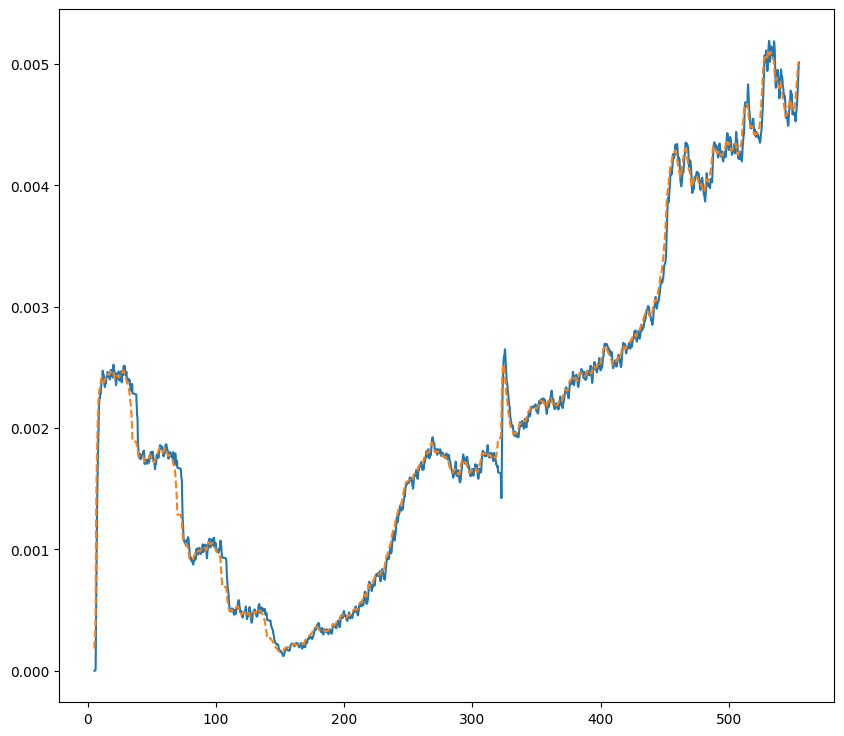

In [292]:
plt.figure(figsize=(10,9))
plt.plot(fit_9["time"][:(2*largo)//3], filter_9_kalman, linestyle="-")
plt.plot(fit_9["time"][:(2*largo)//3], smooth_9_kalman, linestyle="--")


In [286]:
print(future_R_ds)

[np.float64(0.005012386567086598), np.float64(0.005012386567086598), np.float64(0.005012386567086598), np.float64(0.005012386567086598), np.float64(0.005012386567086598), np.float64(0.005012386567086598), np.float64(0.005012386567086598), np.float64(0.005012386567086598), np.float64(0.005012386567086598), np.float64(0.005012386567086598), np.float64(0.005012386567086598), np.float64(0.005012386567086598), np.float64(0.005012386567086598), np.float64(0.005012386567086598), np.float64(0.005012386567086598), np.float64(0.005012386567086598), np.float64(0.005012386567086598), np.float64(0.005012386567086598), np.float64(0.005012386567086598), np.float64(0.005012386567086598), np.float64(0.005012386567086598), np.float64(0.005012386567086598), np.float64(0.005012386567086598), np.float64(0.005012386567086598), np.float64(0.005012386567086598), np.float64(0.005012386567086598), np.float64(0.005012386567086598), np.float64(0.005012386567086598), np.float64(0.005012386567086598), np.float64(0.

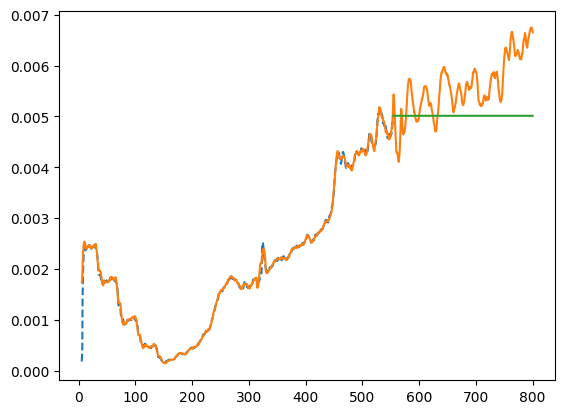

In [287]:
plt.plot(fit_9["time"][:(2*largo)//3], smooth_9_kalman, linestyle="--")
plt.plot(fit_9["time"],smooth_9_savgol)
plt.plot(fit_9["time"][(2*largo)//3:], future_R_ds)
         

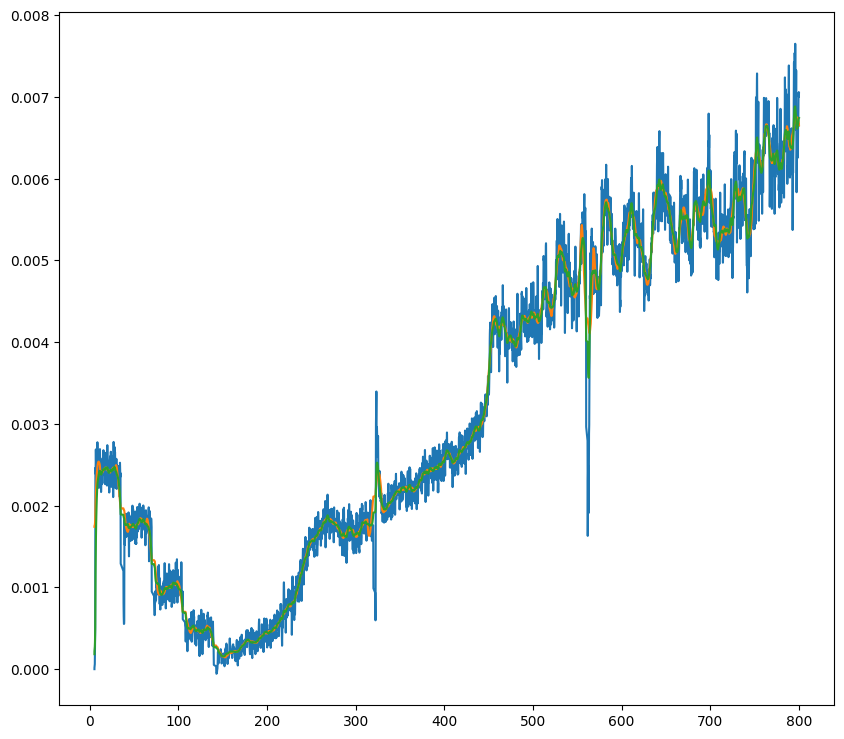

In [ ]:
plt.figure(figsize=(10,9))
plt.plot(fit_9["time"],R_ds)
plt.plot(fit_9["time"],smooth_9_savgol)
plt.plot(fit_9["time"],smooth_9_kalman)

In [252]:
popt2, pcov2 = curve_fit(func_2, fit_9["time"][:(2*largo)//3], smooth_9_savgol[:(2*largo)//3], p0=(1, 0.01))
fiited_9_2 = func_2(fit_9["time"], *popt2)


print(popt2)

[0.00120773 0.00299505]


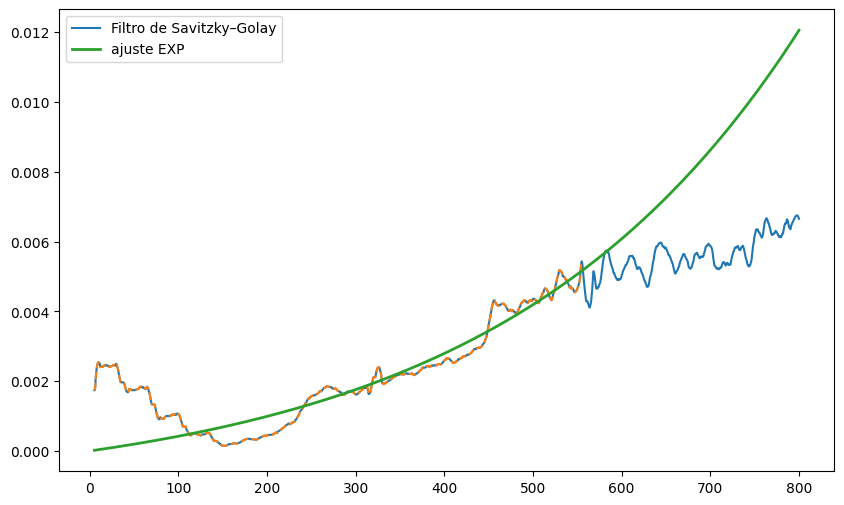

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(fit_9["time"], smooth_9_savgol, label="Filtro de Savitzky–Golay")
plt.plot(fit_9["time"][:(2*largo)//3], smooth_9_savgol[:(2*largo)//3], linestyle="--")
plt.plot(fit_9["time"], fiited_9_2, label = "ajuste EXP", lw=2)
plt.legend()
plt.show()